# What is the distribution of protein lengths (in number of atoms)
The maximum length of proteins in the dataset is 21200, which is quite a lot. How many proteins are there that have this kind of length? how does the distribution look. What can be reasonably removed?

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data_dir = '../data/'
point_cloud_data_path = os.path.join(data_dir, 'point_cloud_dataset')

In [2]:
point_clouds = [os.path.join(point_cloud_data_path, f) for f in os.listdir(point_cloud_data_path)]

In [3]:
num_atoms = []
for f in point_clouds:
    n = np.loadtxt(f).shape[0]
    num_atoms.append(n)

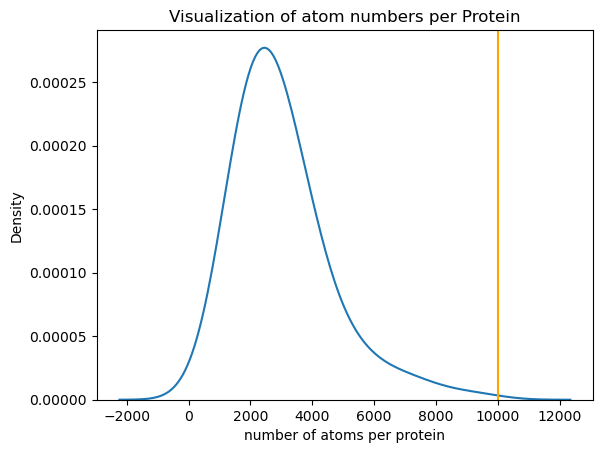

In [4]:
ATM_CUTOFF=10000
ax = sns.kdeplot(np.array(num_atoms), bw_method=0.5)
ax.set(xlabel='number of atoms per protein', 
       ylabel='Density',
       title='Visualization of atom numbers per Protein')
ax.axvline(ATM_CUTOFF, color='orange')
plt.show()

In [5]:
n_discarded = 0
indices = []
for i, n in enumerate(num_atoms):
    if n > ATM_CUTOFF: 
        n_discarded += 1
        indices.append(i)

discarded_proteins = [point_clouds[i] for i in indices]

n_kept = len(num_atoms) - n_discarded    
percent_discarded = (n_discarded / len(num_atoms)) * 100
print(f'n discarded :\t\t{n_discarded}')
print(f'n kept :\t\t{n_kept}')
print(f'percent discarded :\t{percent_discarded} %')

n discarded :		0
n kept :		79394
percent discarded :	0.0 %


# Masking sequences for training the protein encoder

what is a the optimal percentage of masking to train an auto encoder? 

/Users/jonathanfunk/miniforge3/envs/erxn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


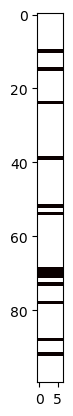

In [6]:
import torch

n = 100
d = 7

sample = torch.zeros(n, d)
mask = torch.FloatTensor(n).uniform_() > 0.15
mask = mask.repeat(7,1).T
masked = torch.masked_fill(sample, mask, value=1)
plt.imshow(masked.numpy(), cmap='hot', interpolation='nearest')

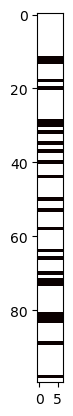

In [7]:
sample = torch.zeros(n, d)
mask = torch.FloatTensor(n).uniform_() > 0.30
mask = mask.repeat(7,1).T
masked = torch.masked_fill(sample, mask, value=1)
plt.imshow(masked.numpy(), cmap='hot', interpolation='nearest')

## Visualizing the protein encoder

Visualizing the different EC levels, starting from high to low

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import sys
sys.path.append('../scripts/')
#from functions.protein_encoder import ProteinEncoder
from functions.pytorchtools import EarlyStopping, invoke, one_hot_encoder, collate_point_cloud, get_acc, load_progress
from functions.customDataset import point_cloud_dataset
from sklearn.metrics import matthews_corrcoef

# Define hyper parameters with Argument Parser
from argparse import ArgumentParser

/Users/jonathanfunk/miniforge3/envs/erxn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '../data'
results_dir = '../results'
processed_data_dir = os.path.join(data_dir, 'processed')
pdb_files_path = os.path.join(data_dir, 'pdbs')
point_cloud_path = os.path.join(data_dir, 'point_cloud_dataset')
hyperparam_dir = os.path.join(results_dir, 'hyper_param_benchmark')

In [3]:
import torch
import torch.nn as nn


class PatchEmbed(nn.Module):
    """Split enzyme into patches and then embed them.
    Parameters
    ----------
    enz_shape : tuple
        Shape of the enzyme encoding.
    patch_length : int
        Number of atoms that shoud be included per patch.
    in_chans : int
        Number of input channels. (potentially interessting for future applications,
        like including hydrophobicity, charge, ...)
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    n_patches : int
        Number of patches of enzyme.
    patch_size : tuple
        Shape of patch (patch_size, enz_shape[1])
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """

    def __init__(self, enz_shape, patch_length, in_chans=1, embed_dim=768):
        super().__init__()
        self.enz_shape = enz_shape
        self.patch_size = (patch_length, enz_shape[1])
        self.n_patches = enz_shape[0] // patch_length

        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=self.patch_size,
            stride=patch_length,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, enz_shape[0], enz_shape[1])`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(
            x
        )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)
        return x


class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The out dimension of the query, key and value.
    n_heads : int
        Number of attention heads.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    attn_p : float
        Dropout probability applied to the query, key and value tensors.
    proj_p : float
        Dropout probability applied to the output tensor.
    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """

    def __init__(self, dim=768, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
            n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_samples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
            2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
                     q @ k_t
             ) * self.scale  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
            1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x


class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """

    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
            x
        )  # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x


class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """

    def __init__(self, dim=768, n_heads=12, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
            dim,
            n_heads=n_heads,
            qkv_bias=qkv_bias,
            attn_p=attn_p,
            proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=hidden_features,
            out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


class ProteinEncoder(nn.Module):
    """The enzyme transformer.
    Parameters
    ----------
    enz_shape : tuple
        Shape of enzyme encoding.
    patch_size : int
        Both height and the width of the patch (it is a square).
    in_chans : int
        Number of input channels.
    n_classes : int
        Number of classes.
    embed_dim : int
        Dimensionality of the token/patch embeddings.
    depth : int
        Number of blocks.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.
    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.
    pos_drop : nn.Dropout
        Dropout layer.
    blocks : nn.ModuleList
        List of `Block` modules.
    norm : nn.LayerNorm
        Layer normalization.
    """

    def __init__(
            self,
            enz_shape=(1500, 7),
            patch_length=20,
            in_chans=1,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.enz_shape = enz_shape

        self.patch_embed = PatchEmbed(
            enz_shape=enz_shape,
            patch_length=patch_length,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )  # learned embedding, + 1 for the cls_token
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.reconstruct = nn.Linear(embed_dim, patch_length * enz_shape[1])
        self.head = nn.Linear(embed_dim, n_classes)  # for classification

    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, num_atoms, num_encoding_dimensions)`.
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
            n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        representations = x[:, 1:]  # the representations

        recon = self.reconstruct(representations)
        recon = recon.view(recon.size(0), 1, self.enz_shape[0], self.enz_shape[1])

        x_cls = self.head(cls_token_final)

        return representations

In [4]:
N_CLASSES = 1022

model = ProteinEncoder(
    enz_shape=(10000,7),
    patch_length=200,
    in_chans=1,
    n_classes=N_CLASSES,
    embed_dim=512,
    depth=12,
    n_heads=8,
    mlp_ratio=4.,
    qkv_bias=False,
    p=0.1,
    attn_p=0.1
)

model.load_state_dict(torch.load(os.path.join(results_dir, 'third_run/11_protein_encoder'), map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
# load dataset
dataset_path = os.path.join(data_dir, 'datasets/09_balanced_data_set.csv')
dataset = pd.read_csv(dataset_path)
_, encoder = one_hot_encoder(dataset['EC'].to_list())

dataset

,protein,EC
0,P07327.txt,1.1.1.1
1,P25405.txt,1.1.1.1
2,P00326.txt,1.1.1.1
3,P80222.txt,1.1.1.1
4,P06525.txt,1.1.1.1
...,...,...
73310,Q326G9.txt,7.6.2.15
73311,Q83MG3.txt,7.6.2.15
73312,Q9KP42.txt,7.6.2.15
73313,Q7MPC5.txt,7.6.2.15


### EC level 1

In [6]:
lvl1_labels = dataset['EC'].to_list()
lvl1_labels = [int(i[0]) for i in lvl1_labels]

lvl1_data = pd.DataFrame(
    {
        'protein':dataset['protein'].to_list(),
        'EC':lvl1_labels
    }
) 
lvl1_data

,protein,EC
0,P07327.txt,1
1,P25405.txt,1
2,P00326.txt,1
3,P80222.txt,1
4,P06525.txt,1
...,...,...
73310,Q326G9.txt,7
73311,Q83MG3.txt,7
73312,Q9KP42.txt,7
73313,Q7MPC5.txt,7


In [22]:
sample_size = 150
lvl1_data_sample = lvl1_data.groupby('EC').apply(lambda x: x.sample(sample_size,random_state=1234))
indices = list(lvl1_data_sample.index.get_level_values(None))
labels = list(lvl1_data_sample.index.get_level_values('EC'))

lvl1_data_sample['EC'] = one_hot_encoder(dataset['EC'].iloc[indices].to_list(),encoder)[0]
lvl1_data_sample

protein                                                 EC
EC                                                                     
1  3456   B5FJQ1.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
   6491   Q562C9.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
   3353   A4SLJ1.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
   2784   B3QPW0.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
   3006   Q47Y92.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
...              ...                                                ...
7  73211  Q660M8.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
   71311  P20684.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
   71281  P24989.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
   70713  Q71MY6.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
   71050  P43208.txt  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

[1050 rows x 2 columns]

In [23]:
from torch.utils.data import Dataset
class point_cloud_dataset(Dataset):
    def __init__(self, df, point_cloud_path):
        self.annotations = df
        self.point_cloud_path = point_cloud_path

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        point_cloud_path = self.point_cloud_path + '/' + self.annotations.iloc[index, 0]
        protein = torch.tensor(np.loadtxt(point_cloud_path))
        y = torch.tensor(self.annotations.iloc[index, 1])
        return (protein, y)

In [24]:
lvl1_dataset = point_cloud_dataset(
    lvl1_data_sample,
    point_cloud_path=point_cloud_path
)

lvl1_dataloader = torch.utils.data.DataLoader(
    lvl1_dataset,
    batch_size=len(lvl1_dataset),
    collate_fn=collate_point_cloud,
    pin_memory=False,
    shuffle=False
)

In [25]:
model.eval()
for i, (x_train, y_train, _, _) in enumerate(lvl1_dataloader):
    out = model(x_train)
    out = out.view(out.size(0), out.size(1)*out.size(2))

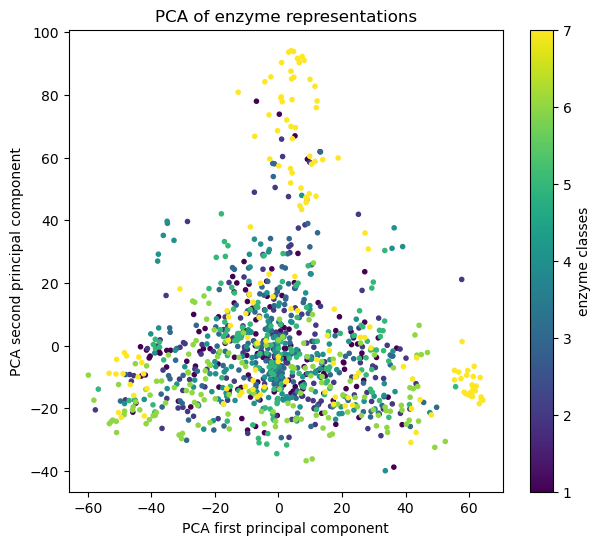

In [27]:
import numpy as np
from sklearn.decomposition import PCA
X = out.detach().numpy()
pca = PCA(n_components = 60)
X_pca = pca.fit_transform(X)


fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_pca[:,0], X_pca[:,1], c=np.array(labels), marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
ax.set_title('PCA of enzyme representations')
plt.colorbar(sc, label='enzyme classes')
plt.savefig('../results/PCA_plot.png')